<a href="https://colab.research.google.com/github/lilyzhizhou/Datathon-4/blob/main/Datathon_4_N_Net_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Loading Packages
# importing torch as t
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np

import seaborn as sns
import statsmodels.api as sm
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import warnings

warnings.filterwarnings('ignore')

import torch as t
import numpy as np
from torch.nn.functional import sigmoid, relu, tanh
from torch.optim import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader

from torch.nn import Tanh, Linear, Sequential, Sigmoid, Dropout

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [69]:
# Load in data
data = pd.read_csv('/content/drive/MyDrive/Machine Learning /Datathon #4/data_clean.csv')

data = data.drop('Unnamed: 0',axis = 1)

data.head()

,apache_post_operative,arf_apache,bun_apache,creatinine_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,resprate_apache,sodium_apache,temp_apache,ventilated_apache,wbc_apache,hospital_death,age,bmi,gender,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,ethnicity_African American,ethnicity_Asian,ethnicity_Caucasian,ethnicity_Hispanic,ethnicity_Native American,ethnicity_Other/Unknown
0,0,0.0,NaN,NaN,3.0,6.0,0.0,5.0,NaN,102.0,NaN,0.0,68.0,37.0,NaN,36.7,0.0,NaN,0,25.0,31.95,F,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0
1,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.0,NaN,0.0,103.0,16.0,NaN,36.7,0.0,NaN,0,19.0,NaN,M,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0
2,0,0.0,13.0,0.71,4.0,6.0,0.0,5.0,156.0,113.0,44.2,0.0,130.0,35.0,137.0,36.6,0.0,10.9,0,67.0,27.56,M,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0
3,0,0.0,18.0,0.78,4.0,6.0,0.0,5.0,197.0,133.0,33.5,1.0,138.0,53.0,135.0,35.0,1.0,5.9,0,59.0,57.45,F,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0
4,0,0.0,48.0,2.05,4.0,6.0,0.0,5.0,164.0,120.0,22.6,0.0,60.0,28.0,140.0,36.6,1.0,12.8,0,70.0,NaN,M,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,1,0,0,0


Data Preparation

---



In [70]:
# Drop all NaN variables for gcs_unable
print(data['gcs_unable_apache'].value_counts(dropna=False))

data = data[(data['gcs_unable_apache'] != 1) & (data['gcs_unable_apache'].notna())]

# Drop 'gcs_unable_apache' variable

data = data.drop('gcs_unable_apache', axis = 1)

0.0    53168
1.0      454
NaN      438
Name: gcs_unable_apache, dtype: int64


In [71]:
# Encode Gender Var to Binary
data['gender'] = data['gender'].map({'F': 0, 'M': 1})

In [72]:
# Test code with subset of data

data_test = data[:1000]

data_test.head()

,apache_post_operative,arf_apache,bun_apache,creatinine_apache,gcs_eyes_apache,gcs_motor_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,resprate_apache,sodium_apache,temp_apache,ventilated_apache,wbc_apache,hospital_death,age,bmi,gender,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,ethnicity_African American,ethnicity_Asian,ethnicity_Caucasian,ethnicity_Hispanic,ethnicity_Native American,ethnicity_Other/Unknown
0,0,0.0,NaN,NaN,3.0,6.0,5.0,NaN,102.0,NaN,0.0,68.0,37.0,NaN,36.7,0.0,NaN,0,25.0,31.95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0
2,0,0.0,13.0,0.71,4.0,6.0,5.0,156.0,113.0,44.2,0.0,130.0,35.0,137.0,36.6,0.0,10.9,0,67.0,27.56,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0
3,0,0.0,18.0,0.78,4.0,6.0,5.0,197.0,133.0,33.5,1.0,138.0,53.0,135.0,35.0,1.0,5.9,0,59.0,57.45,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0
4,0,0.0,48.0,2.05,4.0,6.0,5.0,164.0,120.0,22.6,0.0,60.0,28.0,140.0,36.6,1.0,12.8,0,70.0,NaN,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,1,0,0,0
5,0,0.0,10.0,0.83,4.0,6.0,5.0,134.0,94.0,37.2,0.0,58.0,46.0,139.0,36.3,0.0,8.4,0,50.0,25.71,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0


In [73]:
# Randomly sample 70% of the data for training
train_data = data_test.sample(frac = .7, random_state=10)

# Use the remaining 30% for testing
test_data = data_test.drop(train_data.index)

# Check the mean of the 'hospital_death' column in both training and testing data
print('train', train_data['hospital_death'].mean())
print('test', test_data['hospital_death'].mean())

train 0.06428571428571428
test 0.08


- how do we ensure that equal amounts of death = 1 obs are in both sets of data?

In [74]:
# Data Preparation

# Extract the 'hospital_death' column as the target variable for training and testing
Y_train = train_data['hospital_death'].to_numpy()
Y_test = test_data['hospital_death'].to_numpy()

# Extract the features (excluding 'hospital_death') for training and testing
X_train = train_data.drop('hospital_death', axis=1).to_numpy()
X_test = test_data.drop('hospital_death', axis=1).to_numpy()

In [75]:
# Imputation of missing values with MICE
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imputer = IterativeImputer(max_iter = 10, random_state = 42)
X_train = imputer.fit_transform(X_train)
X_test = imputer.fit_transform(X_train)

In [76]:
# Standardize the features to have zero mean and unit variance
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

Initializing Neural Network Parameters in PyTorch

In [77]:
# Number of explanatory variables
data_test.shape
# 34 explanatory variables

(1000, 35)

In [78]:
# Define the number of neurons in the first and second hidden layers
hidden_units_layer_1 = 5
hidden_units_layer_2 = 5

# FIRST LAYER: Define weights and biases for the first layer
W1 = t.randn((34, hidden_units_layer_1), requires_grad=True)
B1 = t.zeros((1, hidden_units_layer_1), requires_grad=True)

# SECOND LAYER: Define weights and biases for the second layer
W2 = t.randn((hidden_units_layer_1, hidden_units_layer_2), requires_grad=True)
B2 = t.zeros((1, hidden_units_layer_2), requires_grad=True)

# THIRD LAYER: Define weights and biases for the output layer
W3 = t.randn((hidden_units_layer_2, 1), requires_grad=True)
B3 = t.zeros((1, 1), requires_grad=True)

Implementing the Forward Pass of a Neural Network in PyTorch

In [79]:
# Define the forward pass of the neural network
def forward(input):
    # First hidden layer with tanh activation
    out = tanh(input @ W1 + B1)

    # Second hidden layer with tanh activation
    out = tanh(out @ W2 + B2)

    # Output layer with sigmoid activation (since it's a binary classification problem)
    out = sigmoid(out @ W3 + B3)
    return out

Preparing Data and Training Utilities for Neural Network Training in PyTorch

In [80]:
# Convert the training data to PyTorch tensors
X = t.Tensor(X_train).type(t.float32)
Y = t.Tensor(Y_train).type(t.float32)

# Create a dataset from tensors to be used with DataLoader
train_dataset = TensorDataset(X, Y)

# Define training hyperparameters
epochs = 2000
learning_rate = 0.01
batch_size = 32

# DataLoader provides batches of data for training
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Define the optimizer (Adam) and include all weights and biases
optimizer = Adam([W1, B1, W2, B2, W3, B3], lr=learning_rate)

# Define the loss function (Binary Cross-Entropy Loss)
loss_fn = t.nn.BCELoss()

Training Loop for a Neural Network in PyTorch

In [81]:
train_loss_list = []

# Train the model for a specified number of epochs
for epoch in range(epochs):
    # Reduce the learning rate every 500 epochs
    if epoch % 500 == 0:
        learning_rate *= .9

    per_epoch_loss_list = []

    # Iterate over all batches of data
    for batch_idx, (X, Y) in enumerate(train_data_loader):
        # Forward pass: Compute predictions
        probs = forward(X)

        # Compute the loss
        loss = loss_fn(probs.view(-1), Y)

        # Backward pass: Compute gradient and update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Record the loss for this batch
        per_epoch_loss_list.append(loss.item())

  # Record the average loss for this epoch
    train_loss_list.append(sum(per_epoch_loss_list) / len(per_epoch_loss_list))

Visualizing Training Loss Over Epochs with Matplotlib in Python

Text(0, 0.5, 'loss')

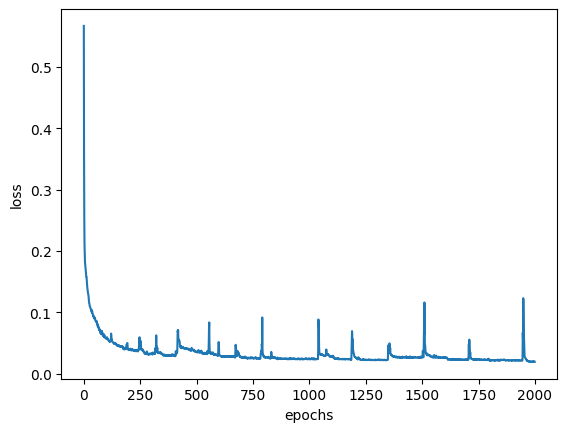

In [82]:
# Plot the training loss over epochs
plt.plot([i for i in range(len(train_loss_list))], train_loss_list)
plt.xlabel('epochs')
plt.ylabel('loss')

Evaluating Model Performance on Validation Data

In [83]:
# Evaluate Model Performance on Validation Data

# Disable gradient calculations for evaluation using t.no_grad()
with t.no_grad():
    # Prepare the validation data
    X = t.Tensor(X_test).type(t.float32)  # Convert validation features to a PyTorch tensor
    Y = t.Tensor(Y_test).type(t.float32)  # Convert validation labels to a PyTorch tensor

    # Calculate predictions on the validation data
    probs = forward(X)  # Pass validation data through the trained model
    loss = loss_fn(probs.view(-1), Y)  # Compute the loss between predictions and actual labels

    # Print the validation loss
    print(loss.item())

    # Now, evaluate the model on the training data
    X = t.Tensor(X_train).type(t.float32)  # Convert training features to a PyTorch tensor
    Y = t.Tensor(Y_train).type(t.float32)  # Convert training labels to a PyTorch tensor

    # Calculate predictions on the training data
    probs = forward(X)  # Pass training data through the trained model
    loss = loss_fn(probs.view(-1), Y)  # Compute the loss between predictions and actual labels

    # Print the training loss
    print(loss.item())

ValueError: ignored


Regularized Training of a Neural Network in PyTorch

In [ ]:
import torch as t
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

# Regularization
# Deep neural networks are prone to overfitting if there is not much data available during training.

# Define hyperparameters
number_of_input_features = 12
number_of_hidden_units = 5
epochs = 100
learning_rate = 0.01
batch_size = 32
landa = 0.01  # Regularization term (lambda)

# Prepare the data
X_train_tensor = t.Tensor(X_train).type(t.float32)
Y_train_tensor = t.Tensor(Y_train).type(t.float32)

X_test_tensor = t.Tensor(X_test).type(t.float32)
Y_test_tensor = t.Tensor(Y_test).type(t.float32)

train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Define the neural network model with regularization
model = nn.Sequential(
    nn.Linear(number_of_input_features, number_of_hidden_units),  # Linear layer for matrix multiplication and bias addition
    nn.Tanh(),  # Tanh activation function
    nn.Linear(number_of_hidden_units, 1),  # Another linear layer
    nn.Sigmoid()  # Sigmoid activation for probability output
)

# Define the optimizer
optimizer = Adam(model.parameters(), lr=learning_rate)

# Define the loss function with Binary Cross-Entropy Loss
loss_fn = nn.BCELoss()

# Lists to store training accuracy, validation accuracy, and training loss over epochs
train_accuracy_list = []
validation_accuracy_list = []
train_loss_list = []

for epoch in range(epochs):
    if epoch % 500 == 0:
        learning_rate *= 0.9  # Learning rate scheduling

    per_epoch_loss_list = []

    for batch_idx, (X, Y) in enumerate(train_data_loader):
        # Forward pass: Compute predictions
        probs = model(X)

        # Adding regularization term for all parameters in the model
        l2_term = sum([(w ** 2).sum() for w in model.parameters()])

        # New loss is the old loss + regularization term
        loss = loss_fn(probs.view(-1), Y) + landa * l2_term

        per_epoch_loss_list.append(loss.item())

        # Backward pass: Compute gradient and update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Evaluate the model on training and validation data
    with t.no_grad():
        # Set the model in eval mode; some layers use this for certain calculations during training
        model.eval()

        # Calculate accuracy on train data
        probs = model(X_train_tensor)
        prediction = (probs >= 0.5).type(t.LongTensor).view(-1)
        train_accuracy = (prediction == Y_train_tensor).type(t.float32).mean().item()

        # Calculate accuracy on validation data
        probs = model(X_test_tensor)
        prediction = (probs >= 0.5).type(t.LongTensor).view(-1)
        validation_accuracy = (prediction == Y_test_tensor).type(t.float32).mean().item()

        # Print accuracy for the current epoch
        print(f'Epoch {epoch}/{epochs} ---> Train Accuracy: {train_accuracy}, Validation Accuracy: {validation_accuracy}')

        # Set the model back to train mode
        model.train()

        # Append accuracy values to lists
        train_accuracy_list.append(train_accuracy)
        validation_accuracy_list.append(validation_accuracy)

    # Calculate and append the average loss for the epoch
    train_loss_list.append(sum(per_epoch_loss_list) / len(per_epoch_loss_list))